In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [118]:
DATASET_DIR = "dataset"
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 2
N_SPLITS = 5
SEED = 1000
MODEL = 'Modelo Proposto'

In [119]:
def build_cnn():
    model = models.Sequential([
        Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        Conv2D(1, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(2, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(3, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=1e-4)
    
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [120]:
datagen = ImageDataGenerator(rescale=1./255)

data_flow = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

X, y = [], []
for i in range(len(data_flow)):
    imgs, labels = data_flow[i]
    X.append(imgs)
    y.append(labels)
    if (i+1)*BATCH_SIZE >= data_flow.samples:
        break

X = np.vstack(X)
y = np.hstack(y).astype(int)

print("Dataset carregado:", X.shape, y.shape)

Found 1265 images belonging to 2 classes.
Dataset carregado: (1265, 224, 224, 3) (1265,)


In [121]:
orig_class_indices = dict(data_flow.class_indices)
print("Mapeamento original:", orig_class_indices)

# Keras geralmente mapeia em ordem alfabética: bleached=0, unbleached=1.
# Queremos padronizar: unbleached=0, bleached=1
if orig_class_indices.get('bleached', None) == 0:
    print("⚠️ 'bleached' está como 0. Invertendo labels para padronizar bleached=1.")
    y = 1 - y
    class_indices = {'unbleached': 0, 'bleached': 1}
else:
    class_indices = orig_class_indices

inv_class_indices = {v: k for k, v in class_indices.items()}
label_names = [inv_class_indices[0], inv_class_indices[1]]  # ["unbleached","bleached"]
print("Mapeamento efetivo utilizado:", class_indices)

Mapeamento original: {'bleached': 0, 'unbleached': 1}
⚠️ 'bleached' está como 0. Invertendo labels para padronizar bleached=1.
Mapeamento efetivo utilizado: {'unbleached': 0, 'bleached': 1}


In [122]:
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

results = {"accuracy": [], "precision": [], "recall": [], "f1": [], "loss": []}
conf_matrices = []

fold = 1
for train_idx, test_idx in skf.split(X, y):
    print(f"\n===== Fold {fold} =====")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = build_cnn()

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        mode='max', # 'max' para acurácia, 'min' para perda
        restore_best_weights=True,
        verbose=1
    )

    rlr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.2, patience=10, verbose=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1
    )

    # Predições
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob.ravel() >= 0.5).astype(int)

    # Métricas (bleached = 1 como classe positiva)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    rec  = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1   = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    loss = model.evaluate(X_test, y_test, verbose=0)[0]

    print(f"Acurácia: {acc:.4f}, Precisão (bleached): {prec:.4f}, Recall (bleached): {rec:.4f}, F1 (bleached): {f1:.4f}, Loss: {loss:.4f}")

    results["accuracy"].append(acc)
    results["precision"].append(prec)
    results["recall"].append(rec)
    results["f1"].append(f1)
    results["loss"].append(loss)

    # Matriz de confusão do fold (labels fixos [0,1] = [unbleached, bleached])
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    conf_matrices.append(cm)

    fold += 1


===== Fold 1 =====
Epoch 1/2
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5148 - loss: 0.7220 - val_accuracy: 0.5731 - val_loss: 0.6662
Epoch 2/2
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5860 - loss: 0.6754 - val_accuracy: 0.5968 - val_loss: 0.6555
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Acurácia: 0.5968, Precisão (bleached): 0.6429, Recall (bleached): 0.5373, F1 (bleached): 0.5854, Loss: 0.6555

===== Fold 2 =====
Epoch 1/2
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5425 - loss: 0.6909 - val_accuracy: 0.5138 - val_loss: 0.6945
Epoch 2/2
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5702 - loss: 0.6737 - val_accuracy: 0.5968 - val_loss: 0.6759
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Acurácia: 0.5968, Precisão (bleached): 0.7353, Recall (bleached): 0.3731, F1 (bleached): 0.4950, Loss: 0.6759

===== Fold 3 =====
Epoch 1/2
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5277 - loss: 0.6930 - val_accuracy: 0.5296 - val_loss: 0.6925
Epoch 2/2

In [113]:
print("\n===== MÉDIAS DOS RESULTADOS DOS FOLDS =====")
for metric in results.keys():
    print(f"{metric.capitalize()}: {np.mean(results[metric]):.4f} (+/- {np.std(results[metric]):.4f})")



===== MÉDIAS DOS RESULTADOS DOS FOLDS =====
Accuracy: 0.5968 (+/- 0.0198)
Precision: 0.6008 (+/- 0.0233)
Recall: 0.5953 (+/- 0.0265)
F1: 0.5873 (+/- 0.0321)
Loss: 0.6716 (+/- 0.0111)


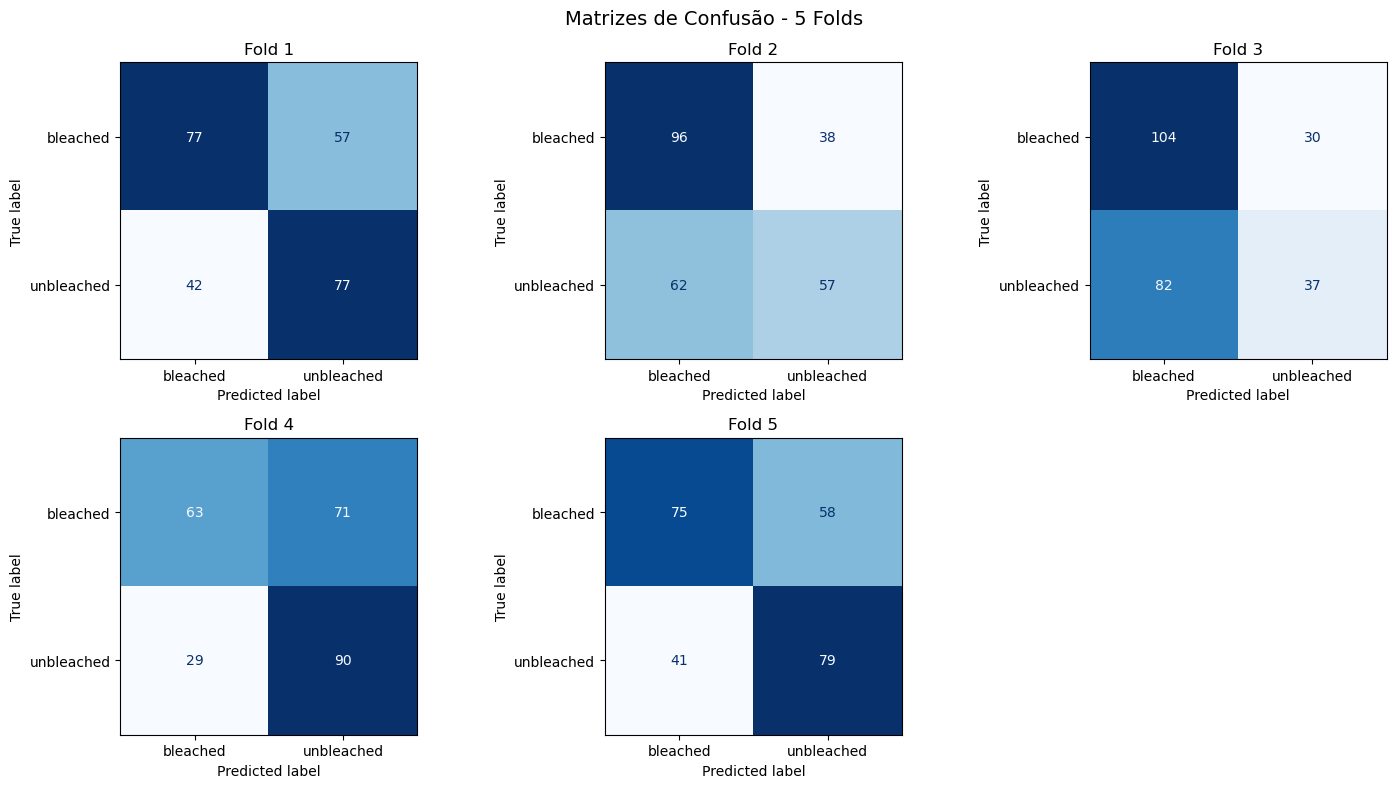

In [114]:
n = len(conf_matrices)
ncols = 3 if n > 2 else n
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
if nrows == 1 and ncols == 1:
    axes = np.array([axes])
axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

for i, cm in enumerate(conf_matrices):
    # Reorganiza a matriz para ter TP no canto superior esquerdo (classe 1)
    cm_reordered = np.array([[cm[1,1], cm[1,0]],
                             [cm[0,1], cm[0,0]]])
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_reordered, display_labels=["bleached", "unbleached"])
    disp.plot(cmap="Blues", ax=axes[i], colorbar=False)
    axes[i].set_title(f"Fold {i+1}")

# Remove subplots vazios se existirem
for j in range(len(conf_matrices), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(f"Matrizes de Confusão - {n} Folds", fontsize=14)
plt.tight_layout()
plt.show()

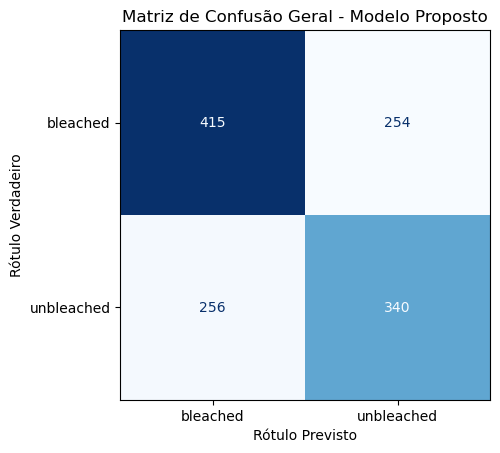

In [115]:
cm_total = sum(conf_matrices)

# Reordena para que 'bleached' (classe positiva) apareça primeiro
# assumindo que label_names = ["unbleached", "bleached"]
labels_ordered = ["bleached", "unbleached"]
cm_total_reordered = confusion_matrix(
    y_true=[], y_pred=[],  # truques para reordenar
    labels=labels_ordered
)
cm_total_reordered = cm_total[[1,0]][:,[1,0]]  # reorganiza manualmente

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm_total_reordered,
                              display_labels=labels_ordered)
disp.plot(cmap="Blues", colorbar=False)

plt.title(f"Matriz de Confusão Geral - {MODEL}")
plt.xlabel("Rótulo Previsto")
plt.ylabel("Rótulo Verdadeiro")

plt.show()

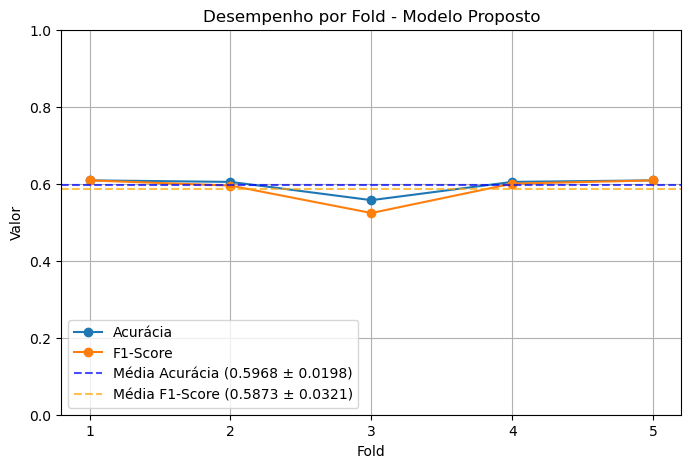

In [116]:
folds = np.arange(1, N_SPLITS+1)

acc_mean = np.mean(results["accuracy"])
acc_std = np.std(results["accuracy"])
f1_mean = np.mean(results["f1"])
f1_std = np.std(results["f1"])

plt.figure(figsize=(8,5))

# Curvas por fold
plt.plot(folds, results["accuracy"], marker="o", label="Acurácia")
plt.plot(folds, results["f1"], marker="o", label="F1-Score")

# Linhas horizontais das médias
plt.axhline(acc_mean, color="blue", linestyle="--", alpha=0.7, label=f"Média Acurácia ({acc_mean:.4f} ± {acc_std:.4f})")
plt.axhline(f1_mean, color="orange", linestyle="--", alpha=0.7, label=f"Média F1-Score ({f1_mean:.4f} ± {f1_std:.4f})")

# Configurações do gráfico
plt.title(f"Desempenho por Fold - {MODEL}")
plt.xlabel("Fold")
plt.ylabel("Valor")
plt.xticks(folds)
plt.ylim(0, 1)
plt.legend(loc="lower left")
plt.grid(True)
plt.show()